In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, roc_auc_score, r2_score
from window_ops.rolling import rolling_mean, rolling_max, rolling_min
import holidays
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import plotly.io as pio
import plotly.graph_objects as go
import math


In [2]:
def sin_cos_transform(series, divisor=-1):
    """
    Apply sin cos transformation to get cyclical features.

    Args:
        series (iterable): Series to transform
        divisor (int): Divisor value. If it doesn't set, function gets max value of series.

    Returns:
        - sin_values (list) - Sin transformed values
        - cos_values (list) - Cos transformed values
    """
    if divisor == -1:
        divisor = series.max()
    sin_values = [math.sin((2 * math.pi * x) / divisor) for x in list(series)]
    cos_values = [math.cos((2 * math.pi * x) / divisor) for x in list(series)]
    return sin_values, cos_values

In [3]:
# Function to check if a date is a US holiday
def is_us_holiday(date):
    us_holidays = holidays.US(years=date.year)
    return date in us_holidays


def create_features(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    df["day_of_week_sin"], df["day_of_week_cos"] = sin_cos_transform(df.index.dayofweek, divisor=7)
    df["day_of_month_sin"], df["day_of_month_cos"] = sin_cos_transform(df.index.day, divisor=30)
    df["month_sin"], df["month_cos"] = sin_cos_transform(df.index.month, divisor=12)


    df['day_of_quarter'] = (df.index.dayofyear - 1) % 91 + 1
    df['week_of_month'] = df.index.day // 7 + 1
    df['quarter_of_year'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week.astype('int32')
    df["is_wknd"] = df.index.weekday // 4
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['season'] = df['month'] % 12 // 3 + 1
    df['lag7_births'] = df['births'].shift(periods=7)
    df['lag14_births'] = df['births'].shift(periods=14)
    df['lag4_births'] = df['births'].shift(periods=4)
    df['lag6_births'] = df['births'].shift(periods=6)
    df['births_diff7'] = df['births'].shift(7) - df['births'].shift(14)
    window_size = 7
    df['rolling_std'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").std()

    # Calculate the rolling mean, max, and min for the relevant columns
    df['rolling_mean'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").mean()
    df['rolling_max'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").max()
    df['rolling_min'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").min()
    # Add 'is_us_holiday' column to DataFrame
    df['is_us_holiday'] = df.index.map(is_us_holiday).astype(int)
    return df


In [4]:
df = pd.read_csv("Births2015.csv")
df = df.drop(columns = ['Unnamed: 0', 'wday'], axis = 1)
df['date'] = pd.to_datetime(df['date'])
df.describe()
df = df.set_index('date')

In [5]:
df  =create_features(df)

In [6]:
df = df.dropna()

In [7]:
FEATURES= ['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'day_of_quarter', 'is_wknd',
       'lag7_births', 'lag14_births', 'rolling_std', 'rolling_mean',
       'rolling_max', 'rolling_min', 'is_us_holiday']
TARGET = 'births'

In [8]:
train = df[:-60]
val = df[-60:-30]
test = df[-30:]

In [9]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_val = val[FEATURES]
y_val = val[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [10]:
y_val.max()

13185

In [90]:
# normalize
import torch
import matplotlib.pyplot as plt
import copy
from sklearn.preprocessing import StandardScaler
mScalar = StandardScaler()
mScalar.fit(X_train)
X_train_scaled = mScalar.fit_transform(X_train)
X_val_scaled = mScalar.transform(X_val)
X_test_scaled = mScalar.transform(X_test)

X_train_tensor = torch.from_numpy(X_train_scaled).float()
X_val_tensor = torch.from_numpy(X_val_scaled).float()
X_test_tensor = torch.from_numpy(X_test_scaled).float()

y_train_tensor = torch.from_numpy(y_train.values).float()/15000
y_val_tensor = torch.from_numpy(y_val.values).float()/15000
y_test_tensor = torch.from_numpy(y_test.values).float()/15000

In [91]:
class mMLP(torch.nn.Module):
    def __init__(self, input_dim, out_dim):
        super(mMLP, self).__init__()
        self.layer1 = torch.nn.Linear(input_dim, 64)
        self.layer2 = torch.nn.Linear(64, 128)
        self.layer3 = torch.nn.Linear(128, 32)
        self.layer4 = torch.nn.Linear(32, 32)
        self.layer5 = torch.nn.Linear(32, 16)
        self.layer6 = torch.nn.Linear(16, out_dim)

        self.act_func = torch.nn.ReLU()

    def forward(self, x_):
        out1 = self.layer1(x_)
        out1 = self.act_func(out1)

        out1 = self.layer2(out1)
        out1 = self.act_func(out1)

        out1 = self.layer3(out1)
        out1 = self.act_func(out1)

        out1 = self.layer4(out1)
        out1 = self.act_func(out1)

        out1 = self.layer5(out1)
        out1 = self.act_func(out1)
        
        out1 = self.layer6(out1)
        return out1

In [92]:
mModel.parameters

<bound method Module.parameters of mMLP(
  (layer1): Linear(in_features=15, out_features=64, bias=True)
  (layer2): Linear(in_features=64, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=32, bias=True)
  (layer5): Linear(in_features=32, out_features=16, bias=True)
  (layer6): Linear(in_features=16, out_features=1, bias=True)
  (act_func): ReLU()
)>

c:\Users\ipek\Desktop\staj-DATABOSS\MLproject\.env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([291])) that is different to the input size (torch.Size([291, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

c:\Users\ipek\Desktop\staj-DATABOSS\MLproject\.env\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning:

Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



epoch    0: train_loss: 0.29837590 val_loss: 0.29134384, min_val_loss is at epoch:    0, : 0.29134384
epoch  100: train_loss: 0.28541136 val_loss: 0.27862534, min_val_loss is at epoch:  100, : 0.27862534
epoch  200: train_loss: 0.27307129 val_loss: 0.26652443, min_val_loss is at epoch:  200, : 0.26652443
epoch  300: train_loss: 0.26132247 val_loss: 0.25500837, min_val_loss is at epoch:  300, : 0.25500837
epoch  400: train_loss: 0.25013331 val_loss: 0.24404632, min_val_loss is at epoch:  400, : 0.24404632
epoch  500: train_loss: 0.23947559 val_loss: 0.23360977, min_val_loss is at epoch:  500, : 0.23360977
epoch  600: train_loss: 0.22932236 val_loss: 0.22367242, min_val_loss is at epoch:  600, : 0.22367242
epoch  700: train_loss: 0.21965022 val_loss: 0.21420623, min_val_loss is at epoch:  700, : 0.21420623
epoch  800: train_loss: 0.21043499 val_loss: 0.20518868, min_val_loss is at epoch:  800, : 0.20518868
epoch  900: train_loss: 0.20165300 val_loss: 0.19659950, min_val_loss is at epoch:

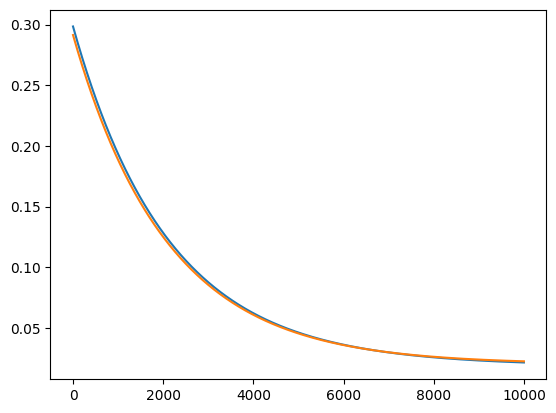

In [100]:
torch.manual_seed(42)
mModel = mMLP(input_dim=15, out_dim=1)
MAX_EPOCH = 10000
mOptimizer = torch.optim.SGD(params=mModel.parameters(), lr=1e-4)
mLoss = torch.nn.MSELoss()
val_losses_list, train_losses_list = [], []
best_model = None
min_val_loss = np.inf
for epoch_indx in range(MAX_EPOCH):
    train_preds = mModel.forward(X_train_tensor)

    
    loss = mLoss(train_preds, y_train_tensor)
    train_losses_list.append(loss.item())
    if epoch_indx % 100 == 0:
        print(f"epoch {epoch_indx:4d}: train_loss: {loss.item():.8f}", end=" ")

    mOptimizer.zero_grad()
    loss.backward()
    mOptimizer.step()

    # validation
    with torch.no_grad():
        val_preds = mModel.forward(X_val_tensor)
        val_loss = mLoss(val_preds, y_val_tensor)
        val_losses_list.append(val_loss.item())
        if epoch_indx % 100 == 0:
            min_val_loss_index = np.argmin(np.asarray(val_losses_list))
            min_val_loss = np.min(np.asarray(val_losses_list))
            print(f"val_loss: {val_loss.item():.8f}, min_val_loss is at epoch: {min_val_loss_index:4d}, : {min_val_loss:.8f}")    
        if min_val_loss > val_loss.item():
            min_val_loss = val_loss.item()
            best_model = copy.deepcopy(mModel)
plt.plot(train_losses_list)
plt.plot(val_losses_list)
plt.show()

In [101]:
with torch.no_grad():
    train_preds = best_model.forward(X_train_tensor).numpy()*15000
    train_preds = pd.DataFrame(train_preds, index=X_train.index)
    val_preds = best_model.forward(X_val_tensor).numpy()*15000
    val_preds = pd.DataFrame(val_preds, index=X_val.index)
    test_preds = best_model.forward(X_test_tensor).numpy()*15000
    test_preds = pd.DataFrame(test_preds, index=X_test.index)

import plotly.io as pio
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=train_preds.index, y=train_preds[0],  name="train_preds", line=dict(color='blue'))
)

fig.add_trace(
    go.Scatter(x=val_preds.index, y=val_preds[0],  name="val_preds", line=dict(color='cyan'))
)
fig.add_trace(
    go.Scatter(x=test_preds.index, y=test_preds[0],  name="test_preds", line=dict(color='orange'))
)

fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_train).index, y=pd.DataFrame(y_train)["births"],  name="train_target", line=dict(color='brown'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_val).index, y=pd.DataFrame(y_val)["births"],  name="val_target", line=dict(color='black'))
)
fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_test).index, y=pd.DataFrame(y_test)["births"],  name="test_target", line=dict(color='green'))
)
fig.update_layout(height=600)
fig.show()

In [18]:
from sklearn.metrics import mean_squared_error

# Convert DataFrame predictions back to NumPy arrays
train_preds = train_preds.values
val_preds = val_preds.values
test_preds = test_preds.values

# Convert DataFrame targets back to NumPy arrays
y_train_numpy = y_train.values
y_val_numpy = y_val.values
y_test_numpy = y_test.values

# Calculate RMSE scores for training, validation, and test sets
train_rmse = np.sqrt(mean_squared_error(y_train_numpy, train_preds))
val_rmse = np.sqrt(mean_squared_error(y_val_numpy, val_preds))
test_rmse = np.sqrt(mean_squared_error(y_test_numpy, test_preds))

print("Train RMSE:", train_rmse)
print("Validation RMSE:", val_rmse)
print("Test RMSE:", test_rmse)


Train RMSE: 2043.7253163964383
Validation RMSE: 2427.1784778293795
Test RMSE: 2892.7766897365586
